<a href="https://colab.research.google.com/github/githubpradeep/notebooks/blob/main/autogen_meme_creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch


In [ ]:
!pip install flamingo-pytorch

In [ ]:
!pip install vit-pytorch

In [4]:
!git clone https://github.com/dhansmair/flamingo-mini.git


Cloning into 'flamingo-mini'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 305 (delta 73), reused 52 (delta 52), pack-reused 220
Receiving objects: 100% (305/305), 1.40 MiB | 3.75 MiB/s, done.
Resolving deltas: 100% (195/195), done.


In [ ]:
%cd flamingo-mini
!pip install .

In [ ]:
from flamingo_mini import FlamingoConfig, FlamingoModel, FlamingoProcessor

model = FlamingoModel.from_pretrained('dhansmair/flamingo-mini')           # or flamingo-tiny
processor = FlamingoProcessor(model.config)

In [7]:
model=model.to('cuda')


In [ ]:
model.eval()

In [9]:
import torch
from flamingo_mini import FlamingoModel, FlamingoProcessor
from flamingo_mini.utils import load_url
device='cuda'

# load and process an example image
print('loading image and generating caption...')
image = load_url('https://raw.githubusercontent.com/rmokady/CLIP_prefix_caption/main/Images/CONCEPTUAL_02.jpg')
caption = model.generate_captions(processor, images=[image], device=device)
print('generated caption:', caption[0])

loading image and generating caption...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


generated caption: tourists under the cherry blossoms


In [10]:
from einops import repeat

def multimodal_prompt(model: FlamingoModel, processor: FlamingoProcessor, prompt: str, images: list, device: torch.device) -> str:
    """few-shot multimodal prompting

    shape for visual_features parameter: [b=batch size, N=number of images, T=1 (number of frames), v=number of visual features, d=dimensionality of visual feature]
    (I haven't checked if it works with videos)
    """
    input_ids, media_locations, attention_mask = processor.encode_text(prompt, device=device)

    pixels = processor(images, device=device)['pixel_values']
    pixels = repeat(pixels, 'N c h w -> b N T c h w', b=1, T=1)

    output = model.generate(
        inputs=input_ids,
        media_locations=media_locations,
        attention_mask=attention_mask,
        pixel_values=pixels,
        max_length=150,
        use_cache=True,
        early_stopping=True,
        bos_token_id=model.flamingo.lm.config.bos_token_id,
        eos_token_id=model.flamingo.lm.config.eos_token_id,
        pad_token_id=model.flamingo.lm.config.eos_token_id
    )

    response = processor.tokenizer.batch_decode(output, skip_special_tokens=True)
    return response[0]

In [11]:
prompt = "<image> A photo of"
response = multimodal_prompt(model, processor, prompt, images=[image], device=device)
print('prompt:', prompt)
print('output:', response)

prompt: <image> A photo of
output: <image> A photo of the cherry blossoms<EOC>


In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [13]:
import os, sys
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageChops

from PIL import Image, ImageChops
class Image_Manager:
    def __init__(self):
        print("Image manager create")

    @staticmethod
    def add_text(
        base,
        text,
        position,
        font_size,
        text_color="black",
        text_width_proportion=4,
        wrapped_width=None,
        rotate_degrees=None,
    ):

        try:
            overlay_image = Image.new("RGBA", base.size, (0, 0, 0, 0))
            font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', font_size)

            draw = ImageDraw.Draw(overlay_image)
            fill = (0, 0, 0, 255)
            if text_color == "white":
                fill = (255, 255, 255, 255)
            lines = textwrap.wrap(text, width=20)
            w, h = 0 , 0
            y_text = position[1]
            for line in lines:
                width, height = font.getsize(line)
                draw.text((position[0], y_text), line, font=font, fill=fill)
                y_text += height
            #draw.text(position, text, font=font, fill=fill)


            if rotate_degrees is not None:
                overlay_image = overlay_image.rotate(rotate_degrees)

            return overlay_image
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(f"error: {e}")
            print(f"line: {exc_tb.tb_lineno}")
            print(f"file: {fname}")
            return "error"


In [14]:
import datetime
import textwrap


In [ ]:
!pip install openai

In [17]:
import openai

In [18]:
openai.api_key=''

In [ ]:
!pip install "pyautogen[mathchat]"

In [21]:
import autogen

config_list = autogen.config_list_from_models(model_list=["gpt-4", "gpt-3.5-turbo", "gpt-3.5-turbo-16k"], exclude="aoai")


In [38]:
def get_description(image):
  print(image)
  image = load_url(image)
  prompt = "<image> A photo of"
  response = multimodal_prompt(model, processor, prompt, images=[image], device=device)
  print('prompt:', prompt)
  return response

In [53]:
def overlay_image(url, meme, text_color = 'black'):
  image = load_url(url)
  position=(10,20)


  with image.convert(
            "RGBA"
        ) as base:
        base = base.resize((300, 300))

        overlay_image = Image_Manager.add_text(
            base=base,
            text=meme,
            position=position,
            font_size=15,
            text_color=text_color,
            rotate_degrees=0,
            wrapped_width=22,
        )

        out = Image.alpha_composite(base, overlay_image)
        if out.mode in ("RGBA", "P"):
            out = out.convert("RGB")
            date = datetime.datetime.now()
            image_name = f"{date}.jpg"
            file_location = f"{image_name}"
            out.save(file_location)
  return file_location

In [99]:
import matplotlib.pyplot as plt

def display_image(file_path):

  img =  Image.open('/content/flamingo-mini/'+file_path)
  plt.imshow(img)
  plt.show()

user_proxy (to chatbot):

describe the image from https://img.freepik.com/premium-photo/gray-scottish-cat-is-lying-by-window-cat-is-wearing-green-sunglasses_650650-3159.jpg
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image 
    and display the image.
    

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: image_desc *****
Arguments: 
{
  "image": "https://img.freepik.com/premium-photo/gray-scottish-cat-is-lying-by-window-cat-is-wearing-green-sunglasses_650650-3159.jpg"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION image_desc...
https://img.freepik.com/premium-photo/gray-scottish-cat-is-lying-by-window-cat-is-wearing-green-sunglasses_650650-3159.jpg
prompt: <image> A photo of
user_proxy (to chatbot):

***** Response fro

<ipython-input-13-e4bdba549a40>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


chatbot (to user_proxy):

***** Suggested function Call: display_image *****
Arguments: 
{
  "file_path": "2023-10-02 15:29:22.997227.jpg"
}
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image...


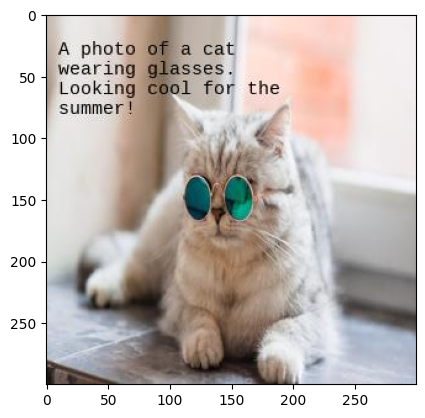

user_proxy (to chatbot):

***** Response from calling function "display_image" *****
None
**********************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [100]:
import os
from autogen.agentchat.contrib.math_user_proxy_agent import MathUserProxyAgent
from PIL import Image

llm_config = {
    "model": "gpt-4-0613",
    "functions": [
        {
            "name": "image_desc",
            "description": "Return the text response after analysing the image from a given url.",
            "parameters": {
                "type": "object",
                "properties": {
                    "image": {
                        "type": "string",
                        "description": "The image url which will be used to download and analyze",
                    }
                },
                "required": ["image"],
            },
        },
        {
            "name": "display_image",
            "description": "Display the image from the file path.",
            "parameters": {
                "type": "object",
                "properties": {
                    "file_path": {
                        "type": "string",
                        "description": "The location of the image",
                    }
                },
                "required": ["file_path"],
            },
        },
        {
            "name": "overlay_meme",
            "description": "Overlays the text on top of the image and saves it and returns the saved filename.",
            "parameters": {
                "type": "object",
                "properties": {
                    "url": {
                        "type": "string",
                        "description": "The image url which will be used to download and analyze",
                    },
                    "meme": {
                        "type": "string",
                        "description": "The meme text which will be used to overlay",
                    },
                    "text_color": {
                        "type": "string",
                        "description": "The color of the meme text",
                    }
                },
                "required": ["url", "meme"],
            },
        }
    ],
    "config_list": config_list,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="Only use the functions you have been provided with. Do not ask user to perform other actions than executing the functions. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# the key in `function_map` should match the function name in "functions" above
# we register a class instance method directly
user_proxy = autogen.UserProxyAgent(
    "user_proxy",
    max_consecutive_auto_reply=4,
    human_input_mode="NEVER",
    function_map={"image_desc": get_description, "overlay_meme": overlay_image, 'display_image': display_image},
)

# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message='''describe the image from https://img.freepik.com/premium-photo/gray-scottish-cat-is-lying-by-window-cat-is-wearing-green-sunglasses_650650-3159.jpg
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image
    and display the image.
    ''',
)

user_proxy (to chatbot):

describe the image from https://en.pimg.jp/102/319/191/1/102319191.jpg
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image 
    and display the image.
    

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: image_desc *****
Arguments: 
{
  "image": "https://en.pimg.jp/102/319/191/1/102319191.jpg"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION image_desc...
https://en.pimg.jp/102/319/191/1/102319191.jpg
prompt: <image> A photo of
user_proxy (to chatbot):

***** Response from calling function "image_desc" *****
<image> A photo of a cat with its mouth open<EOC>
*******************************************************

--------------------------------------------------------------------------------
ch

<ipython-input-13-e4bdba549a40>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


chatbot (to user_proxy):

***** Suggested function Call: display_image *****
Arguments: 
{
  "file_path": "2023-10-02 15:29:57.067758.jpg"
}
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image...


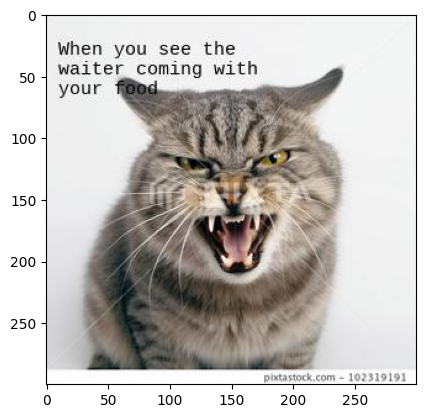

user_proxy (to chatbot):

***** Response from calling function "display_image" *****
None
**********************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [101]:
url = 'https://en.pimg.jp/102/319/191/1/102319191.jpg'
user_proxy.initiate_chat(
    chatbot,
    message=f'''describe the image from {url}
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image
    and display the image.
    ''',
)

user_proxy (to chatbot):

describe the image from https://i.pinimg.com/1200x/64/6b/af/646baf16ffbcc38037dfa7bfb79a9fa8.jpg
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image 
    and display the image.
    

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: image_desc *****
Arguments: 
{
  "image": "https://i.pinimg.com/1200x/64/6b/af/646baf16ffbcc38037dfa7bfb79a9fa8.jpg"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION image_desc...
https://i.pinimg.com/1200x/64/6b/af/646baf16ffbcc38037dfa7bfb79a9fa8.jpg
prompt: <image> A photo of
user_proxy (to chatbot):

***** Response from calling function "image_desc" *****
<image> A photo of a cat with a sad face<EOC>
*******************************************************

---------

<ipython-input-13-e4bdba549a40>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


chatbot (to user_proxy):

***** Suggested function Call: display_image *****
Arguments: 
{
  "file_path": "2023-10-02 15:30:30.202814.jpg"
}
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image...


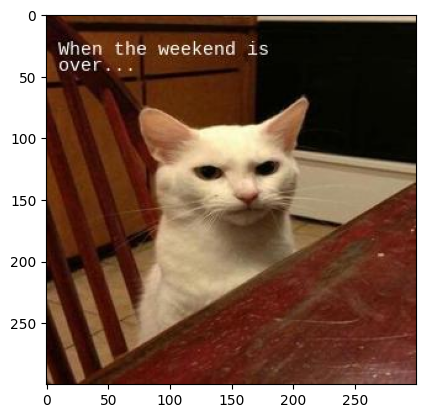

user_proxy (to chatbot):

***** Response from calling function "display_image" *****
None
**********************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [102]:

url = 'https://i.pinimg.com/1200x/64/6b/af/646baf16ffbcc38037dfa7bfb79a9fa8.jpg'
user_proxy.initiate_chat(
    chatbot,
    message=f'''describe the image from {url}
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image
    and display the image.
    ''',
)


user_proxy (to chatbot):

describe the image from https://pyxis.nymag.com/v1/imgs/d6a/dc7/4a5001b7beea096457f480c8808572428b-09-roll-safe.2x.h473.w710.jpg
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image 
    and display the image.

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: image_desc *****
Arguments: 
{
  "image": "https://pyxis.nymag.com/v1/imgs/d6a/dc7/4a5001b7beea096457f480c8808572428b-09-roll-safe.2x.h473.w710.jpg"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION image_desc...
https://pyxis.nymag.com/v1/imgs/d6a/dc7/4a5001b7beea096457f480c8808572428b-09-roll-safe.2x.h473.w710.jpg
prompt: <image> A photo of
user_proxy (to chatbot):

***** Response from calling function "image_desc" *****
<image> A photo of a 

<ipython-input-13-e4bdba549a40>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


chatbot (to user_proxy):

***** Suggested function Call: display_image *****
Arguments: 
{
  "file_path": "2023-10-02 15:34:33.762072.jpg"
}
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image...


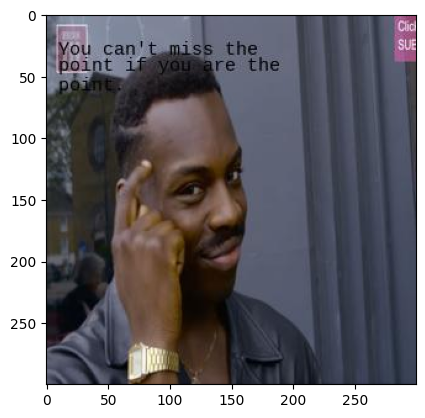

user_proxy (to chatbot):

***** Response from calling function "display_image" *****
None
**********************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [109]:

url = 'https://pyxis.nymag.com/v1/imgs/d6a/dc7/4a5001b7beea096457f480c8808572428b-09-roll-safe.2x.h473.w710.jpg'
user_proxy.initiate_chat(
    chatbot,
    message=f'''describe the image from {url}
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image
    and display the image.''',
)



user_proxy (to chatbot):

describe the image from https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFW2XM9K7CYjvDirQxTQQCdi9JUxWiAyi7pg&usqp=CAU
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image 
    and display the image.

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: image_desc *****
Arguments: 
{
  "image": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFW2XM9K7CYjvDirQxTQQCdi9JUxWiAyi7pg&usqp=CAU"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION image_desc...
https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFW2XM9K7CYjvDirQxTQQCdi9JUxWiAyi7pg&usqp=CAU
prompt: <image> A photo of
user_proxy (to chatbot):

***** Response from calling function "image_desc" *****
<image> A photo of film character fr

<ipython-input-13-e4bdba549a40>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


chatbot (to user_proxy):

***** Suggested function Call: display_image *****
Arguments: 
{
  "file_path": "2023-10-02 15:32:25.868258.jpg"
}
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image...


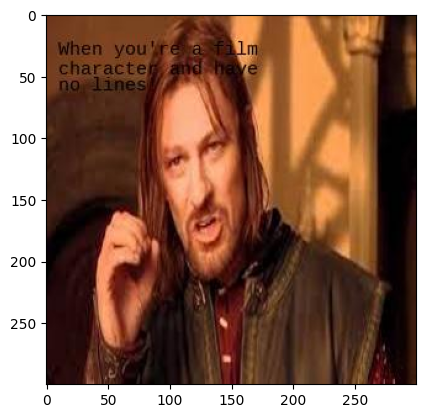

user_proxy (to chatbot):

***** Response from calling function "display_image" *****
None
**********************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [107]:

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFW2XM9K7CYjvDirQxTQQCdi9JUxWiAyi7pg&usqp=CAU'
user_proxy.initiate_chat(
    chatbot,
    message=f'''describe the image from {url}
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image
    and display the image.''',
)




user_proxy (to chatbot):

describe the image from https://i.pinimg.com/236x/31/d0/b1/31d0b18d404474209df237896a435caf.jpg
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image 
    and display the image.

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: image_desc *****
Arguments: 
{
  "image": "https://i.pinimg.com/236x/31/d0/b1/31d0b18d404474209df237896a435caf.jpg"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION image_desc...
https://i.pinimg.com/236x/31/d0/b1/31d0b18d404474209df237896a435caf.jpg


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


prompt: <image> A photo of
user_proxy (to chatbot):

***** Response from calling function "image_desc" *****
<image> A photo of a girl with a long, curly hair<EOC>
*******************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: overlay_meme *****
Arguments: 
{
  "url": "https://i.pinimg.com/236x/31/d0/b1/31d0b18d404474209df237896a435caf.jpg",
  "meme": "When your hair game is on point but it's windy outside",
  "text_color": "white"
}
*************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION overlay_meme...
user_proxy (to chatbot):

***** Response from calling function "overlay_meme" *****
2023-10-02 15:33:19.700899.jpg
*********************************************************

-------------------------------------------------------------------------------

<ipython-input-13-e4bdba549a40>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


chatbot (to user_proxy):

***** Suggested function Call: display_image *****
Arguments: 
{
  "file_path": "2023-10-02 15:33:19.700899.jpg"
}
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image...


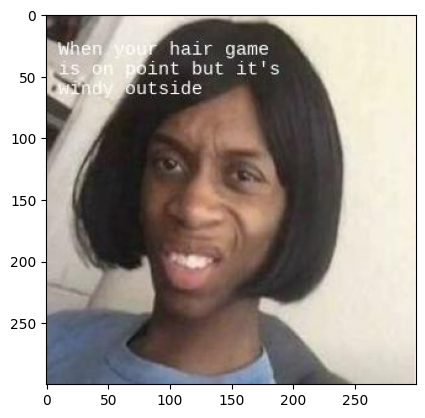

user_proxy (to chatbot):

***** Response from calling function "display_image" *****
None
**********************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [108]:
url = 'https://i.pinimg.com/236x/31/d0/b1/31d0b18d404474209df237896a435caf.jpg'


user_proxy.initiate_chat(
    chatbot,
    message=f'''describe the image from {url}
    and after getting the description write a meme about the description
    and  overlay the meme on top of the image
    and display the image.''',
)



